In [1]:
!pip install Lifetimes

In [2]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [4]:
df_2010_2011 = pd.read_csv("2010_2011.csv", encoding= 'unicode_escape')
df_2010_2011

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [5]:
## checking out datatype and statistical summary

display(df_2010_2011.describe())

display(df_2010_2011.info())

,Quantity,Price,Customer ID
count,541910.000000,541910.000000,406830.000000
mean,9.552234,4.611138,15287.684160
std,218.080957,96.759765,1713.603074
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


None

### Data Cleaning

We can see there some -ve values for quantities and price.
- This could be because those items are returned in those transactions.
- Hence will remove such transactions before CLTV analysis

In [6]:
df = df_2010_2011.copy()
print("Before removing rows ", df.shape)
df = df[df["Quantity"] > 0]
print("After removing negative quantity rows ", df.shape)
df = df[df["Price"] > 0]
print("After removing negative price rows ", df.shape)

Before removing rows  (541910, 8)
After removing negative quantity rows  (531286, 8)
After removing negative price rows  (530105, 8)


We can also see that customer ID missing for some of the rows. 
This means those rows/transactions cannot be identified with any particular customer- hence not useful for CLTV.
Removing rows with missing Customer ID.

### Missing Data Handling

In [7]:
df = df.dropna(subset=['Customer ID','Description'])
print("After removing rows containing missing data ", df.shape)

After removing rows containing missing data  (397885, 8)


In [8]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


### Outlier Handling

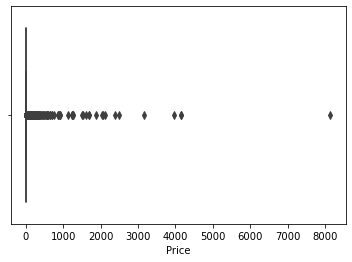

In [9]:
# outliers in price column

sns.boxplot(x=df["Price"])
plt.show()

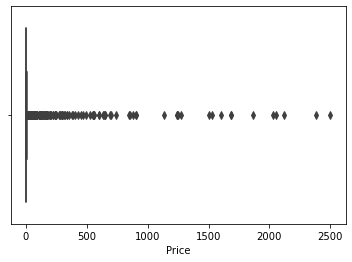

In [10]:
sns.boxplot(x=df[df["Price"]<3000]["Price"])
plt.show()

In [11]:
print("Price column values")
col_name = "Price"

quartile1 = df[col_name].quantile(0.01)
quartile3 = df[col_name].quantile(0.99)
interquantile_range = quartile3 - quartile1
upper_limit = quartile3 + 1.5 * interquantile_range

print("Capping the price to upper_limit")
df.loc[df[col_name] > upper_limit, col_name] = upper_limit
print("quartile1: ", quartile1)
print("quartile3: ", quartile3)
print("low_limit : ", min(df[col_name]), "upper_limit : ", max(df[col_name]))

Price column values
Capping the price to upper_limit
quartile1:  0.21
quartile3:  14.95
low_limit :  0.001 upper_limit :  37.06


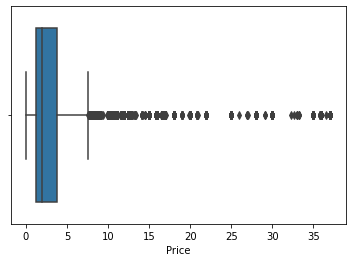

In [12]:
sns.boxplot(x=df[df["Price"]<3000]["Price"])
plt.show()

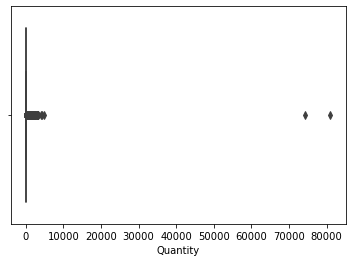

In [13]:
# outliers in quantity column

sns.boxplot(x=df["Quantity"])
plt.show()

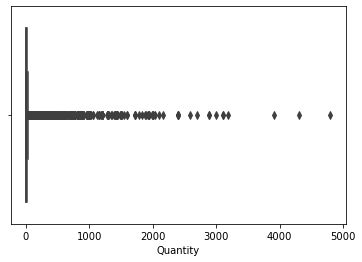

In [14]:
sns.boxplot(x=df[df["Quantity"]<10000]["Quantity"])
plt.show()

In [15]:
print("Quantity column values")
col_name = "Quantity"

quartile1 = df[col_name].quantile(0.01)
quartile3 = df[col_name].quantile(0.99)
interquantile_range = quartile3 - quartile1
up_limit = quartile3 + 1.5 * interquantile_range

print("Capping the quantity to upper_limit")
df.loc[df[col_name] > upper_limit, col_name] = upper_limit
print("quartile1: ", quartile1)
print("quartile3: ", quartile3)
print("low_limit : ", min(df[col_name]), "upper_limit : ", max(df[col_name]))

Quantity column values
Capping the quantity to upper_limit
quartile1:  1.0
quartile3:  120.0
low_limit :  1.0 upper_limit :  37.06


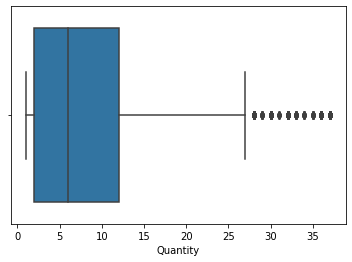

In [16]:
sns.boxplot(x=df[df["Quantity"]<10000]["Quantity"])
plt.show()

In [17]:
### Exploratory Data Analysis

df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

Checking out the number of transactions from each country


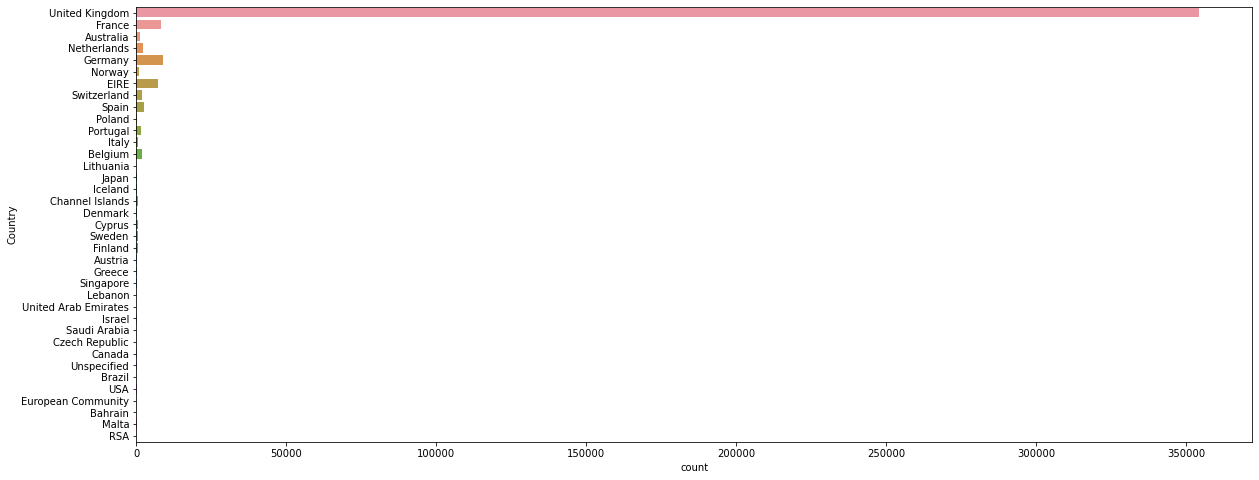

In [18]:
print("Checking out the number of transactions from each country")
plt.figure(figsize=(20, 8))
sns.countplot(y=df["Country"])
plt.show()

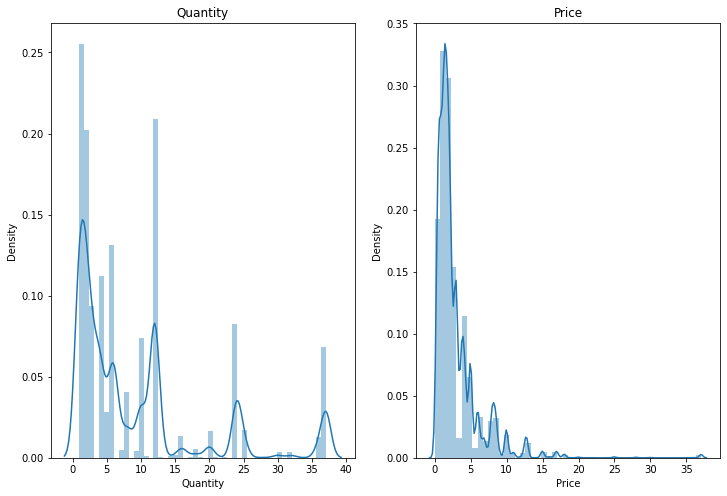

In [19]:
# Checking the distribution of the numeric columns
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(1, 2, 1, title="Quantity")
ax2 = fig.add_subplot(1, 2, 2, title="Price")

sns.distplot(df["Quantity"], ax=ax1)
sns.distplot(df["Price"], ax=ax2)

plt.show()

In [20]:
print("Checking out Invoice date")
df['InvoiceDate'].value_counts()

Checking out Invoice date


11/14/2011 15:27    542
11/28/2011 15:54    533
12/5/2011 17:17     529
11/23/2011 13:39    443
10/31/2011 14:09    435
                   ... 
12/17/2010 12:43      1
4/17/2011 15:29       1
4/17/2011 10:59       1
12/17/2010 13:17      1
3/30/2011 10:18       1
Name: InvoiceDate, Length: 17282, dtype: int64

In [21]:
print("Creating a column with only date and datetime object - Invoice_updated")
df['Invoice_updated'] = df['InvoiceDate'].apply(lambda x : pd.to_datetime(x).date())

Creating a column with only date and datetime object - Invoice_updated


In [22]:
df['StockCode'].nunique()

3665

In [23]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Invoice_updated'],
      dtype='object')

In [24]:
df['Description'].value_counts().values

array([2028, 1723, 1618, ...,    1,    1,    1], dtype=int64)

In [25]:
df['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2028
REGENCY CAKESTAND 3 TIER              1723
JUMBO BAG RED RETROSPOT               1618
ASSORTED COLOUR BIRD ORNAMENT         1408
PARTY BUNTING                         1396
                                      ... 
RUBY GLASS CLUSTER EARRINGS              1
PINK CHRYSANTHEMUMS ART FLOWER           1
72 CAKE CASES VINTAGE CHRISTMAS          1
WALL ART , THE MAGIC FOREST              1
PAPER CRAFT , LITTLE BIRDIE              1
Name: Description, Length: 3877, dtype: int64

In [26]:
item_desc = pd.DataFrame(columns=["item_description", "# times bought"])
item_desc["item_description"] = df['Description'].value_counts().to_dict().keys()
item_desc["# times bought"] = df['Description'].value_counts().to_dict().values()
display(item_desc)

,item_description,# times bought
0,WHITE HANGING HEART T-LIGHT HOLDER,2028
1,REGENCY CAKESTAND 3 TIER,1723
2,JUMBO BAG RED RETROSPOT,1618
3,ASSORTED COLOUR BIRD ORNAMENT,1408
4,PARTY BUNTING,1396
...,...,...
3872,RUBY GLASS CLUSTER EARRINGS,1
3873,PINK CHRYSANTHEMUMS ART FLOWER,1
3874,72 CAKE CASES VINTAGE CHRISTMAS,1
3875,"WALL ART , THE MAGIC FOREST",1


Top 10 most frequently bought items


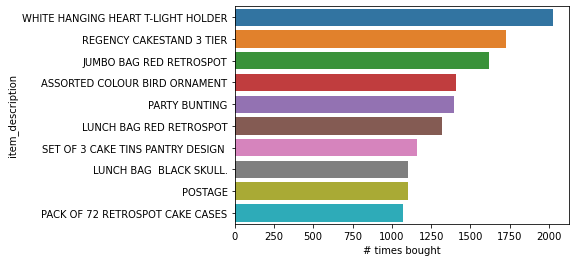

In [27]:
print("Top 10 most frequently bought items")
sns.barplot(x="# times bought", y="item_description", data=item_desc.head(10) )
plt.show()

In [28]:
item_quantity = df.groupby('Description').agg({'Quantity':'sum'}).sort_values(by='Quantity', ascending=False).reset_index()
display(item_quantity)

,Description,Quantity
0,JUMBO BAG RED RETROSPOT,22519.22
1,WHITE HANGING HEART T-LIGHT HOLDER,22487.42
2,ASSORTED COLOUR BIRD ORNAMENT,22451.12
3,PACK OF 72 RETROSPOT CAKE CASES,18899.24
4,WORLD WAR 2 GLIDERS ASSTD DESIGNS,17071.42
...,...,...
3872,WHITE ROSEBUD PEARL EARRINGS,1.00
3873,BLUE LEAVES AND BEADS PHONE CHARM,1.00
3874,CRACKED GLAZE EARRINGS BROWN,1.00
3875,MARIE ANTOIENETT TRINKET BOX GOLD,1.00


Top 10 items wrt # of items


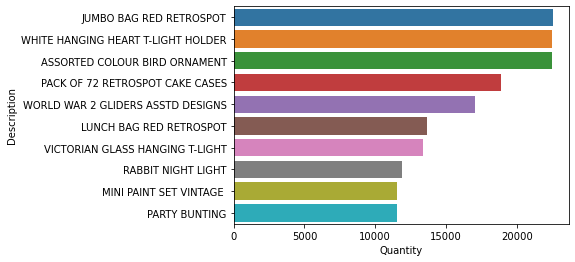

In [29]:
print("Top 10 items wrt # of items")
sns.barplot(x="Quantity", y="Description", data=item_quantity.head(10) )
plt.show()

In [30]:
df["Total_price"] = df["Price"]*df["Quantity"]

In [31]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Invoice_updated,Total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2.0,12/1/2010 8:26,7.65,17850.0,United Kingdom,2010-12-01,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6.0,12/1/2010 8:26,4.25,17850.0,United Kingdom,2010-12-01,25.50
7,536366,22633,HAND WARMER UNION JACK,6.0,12/1/2010 8:28,1.85,17850.0,United Kingdom,2010-12-01,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6.0,12/1/2010 8:28,1.85,17850.0,United Kingdom,2010-12-01,11.10
9,536368,22960,JAM MAKING SET WITH JARS,6.0,12/1/2010 8:34,4.25,13047.0,United Kingdom,2010-12-01,25.50


### Transforming data into RFM format

- Recency : the duration between the customer's last purchase and first purchase
- T : the age of the client in the company
- frequency : total number of repeat purchases
- monetary_value : average earning per purchase

In [32]:
current_date = dt.datetime(2011, 12, 1).date()
current_date

datetime.date(2011, 12, 1)

In [33]:
cltv_data= pd.DataFrame()
cltv_data['recency'] = df.groupby('Customer ID').agg({'Invoice_updated' : lambda date: (date.max() - date.min()).days})
cltv_data['T'] = df.groupby('Customer ID').agg({'Invoice_updated' : lambda date: (current_date - date.min()).days})
cltv_data['frequency'] = df.groupby('Customer ID').agg('Invoice').count()
cltv_data['total_monetary'] = df.groupby('Customer ID').agg('Total_price').sum()

# we need average earning for each customer
cltv_data['monetary'] = cltv_data['total_monetary']/cltv_data['frequency']
cltv_data.drop('total_monetary', axis=1, inplace=True)
cltv_data.head(10)

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,0,317,1,38.542400
12347.0,365,359,182,22.414065
12348.0,283,350,31,31.374148
12349.0,0,10,73,20.434521
12350.0,0,302,17,19.497647
12352.0,260,288,85,20.662824
12353.0,0,196,4,22.250000
12354.0,0,224,58,18.610345
12355.0,0,206,13,27.465385


In [34]:
# The expression of recency and T for BGNBD in weekly terns
cltv_data['recency'] = cltv_data['recency']/7
cltv_data['T'] = cltv_data['T']/7

# we need customers who had 2 or more purchases
print("Number of customers with more than 1 purchases", cltv_data[cltv_data['frequency'] > 1].shape[0])
print("Number of customers with 1 or less purchase", cltv_data[cltv_data['frequency'] <= 1].shape[0])
cltv_data = cltv_data[cltv_data['frequency'] > 1]

Number of customers with more than 1 purchases 4267
Number of customers with 1 or less purchase 71


### BG-NBD Model

In [35]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_data['frequency'], cltv_data['recency'], cltv_data['T'])

ValueError: Some values in recency vector are larger than T vector.

In [ ]:
cltv_data['recency']

In [ ]:
cltv_data['T']